In [1]:
from itertools import islice, combinations, product
from pyclustering.cluster.kmedoids import kmedoids
from scipy.spatial.distance import squareform
from collections import defaultdict
from scipy.stats import hypergeom
from collections import Counter
from goatools import obo_parser
from functools import partial

import os
import time
import graco
import random
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
def get_number_of_max_runs(GV, distance, nb_clusters):
    runs = max(int(run) for run,species,db,ncluster_txt in 
             map(partial(str.split, sep='_'), os.listdir(f"{CLUSTERS_DIRECTORY}/{GV}/{distance}"))
                if int(ncluster_txt.split('.')[0]) == nb_clusters)
    return runs

In [3]:
pd.set_option("display.max_columns", 50)

DATA_DIRECTORY = "/home/clusterduck123/Desktop/git/supplements/data"
CPP_DIRECTORY = "/home/clusterduck123/Desktop/git/graco/graco/cpp"

RAW_DATA_DIRECTORY = f"{DATA_DIRECTORY}/raw_data"
PPI_DIRECTORY = f"{DATA_DIRECTORY}/PPI"
ANNOTATIONS_DIRECTORY = f"{DATA_DIRECTORY}/annotations"
MATRIX_DIRECTORY = f"{DATA_DIRECTORY}/matrix"
CLUSTERS_DIRECTORY = f"{DATA_DIRECTORY}/clusters"

# Analysis

In [13]:
MIN_CLUSTERS = 2
MAX_CLUSTERS = 100

std_dfs = defaultdict(pd.DataFrame)

In [26]:
methods = ['GDV_similarity', 'GDV_mahalanobis']
for method in methods:
    GV, distance = method.split('_')
    
    for run in range(50):
        std_dfs[method][run] = pd.Series(np.nan, index=range(MIN_CLUSTERS, MAX_CLUSTERS))
    
        for nb_clusters in range(MIN_CLUSTERS, MAX_CLUSTERS):
             with open(f"{CLUSTERS_DIRECTORY}/{GV}/{distance}/{run}_sc_BioGRID_{nb_clusters}.txt", 'r') as f:
                std_dfs[method][run][nb_clusters] = np.std([len(line.split()) for line in f])

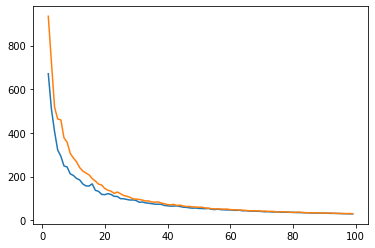

In [27]:
plt.plot(std_dfs[methods[0]].mean(axis=1));
plt.plot(std_dfs[methods[1]].mean(axis=1));

In [19]:
std_dfs[method].mean(axis=1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
2,276.000000,2290.000000,276.000000,263.000000,263.000000,2290.000000,276.000000,263.000000,2290.000000,2290.000000,263.000000,2290.000000,263.000000,201.000000,18.000000,2190.000000,263.000000,276.000000,263.000000,276.000000,2290.000000,2290.000000,18.000000,2290.000000,2290.000000,2290.000000,18.000000,2290.000000,263.000000,276.000000,263.000000,226.000000,263.000000,276.000000,276.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,2290.000000,2290.000000,263.000000,263.000000,263.000000,263.000000,276.000000,263.000000,263.000000
3,989.431599,2088.705234,294.283688,276.976934,503.040312,2088.705234,989.431599,294.283688,655.172412,989.431599,989.431599,2026.937317,974.741789,989.431599,989.431599,939.855426,270.671182,248.393952,503.040312,352.405385,743.761760,789.571332,974.741789,352.405385,958.147634,792.330879,1015.534123,974.741789,989.431599,806.394996,756.418902,225.708268,220.024746,878.735961,278.666268,974.741789,935.700926,556.465233,958.147634,405.983853,352.405385,392.479582,989.431599,985.745854,80.855152,352.405385,173.084437,766.243796,792.330879,2088.705234
4,269.069229,418.880353,453.988161,546.768004,819.163445,858.408557,175.488604,917.059567,298.279651,455.527442,583.041379,806.274302,587.864568,538.624405,567.664293,705.953433,974.998590,597.835471,994.283033,507.994341,638.694958,269.611294,551.770106,327.539692,190.906391,482.843919,246.967103,314.239161,614.375496,636.539276,1150.392650,525.449094,449.407666,548.003878,597.835471,982.044424,273.715637,363.871200,53.068352,436.926481,473.561242,891.503365,851.058312,592.232429,360.389026,705.304721,209.758790,84.833661,588.794744,577.006282
5,410.809640,463.086342,489.676383,576.188997,197.297136,361.628207,666.287746,217.754357,237.938984,324.847903,340.778755,411.721945,538.214976,470.684353,577.445547,421.194207,596.348690,270.275711,597.307090,318.675634,330.820435,477.637268,665.744816,745.061179,102.092899,517.327904,925.388437,417.505641,91.632745,679.732418,281.786018,314.464243,273.710358,374.154193,467.383954,298.250499,693.349090,676.098040,445.651164,341.826506,413.012542,356.383165,588.857674,448.361640,601.242513,912.277896,392.252164,517.541264,356.157493,335.865092
6,540.204180,292.671982,373.748876,166.434839,247.067242,454.144862,320.280953,360.787872,637.586508,354.905934,334.001830,455.743593,456.863826,505.729067,111.455023,282.623228,294.948395,463.017518,448.214854,637.586508,346.684134,343.957685,413.387093,360.007716,446.404027,285.830175,265.212284,348.999841,499.682788,408.539132,591.426994,481.553620,296.392008,273.038866,352.289023,560.387564,344.870346,256.199575,285.904219,699.285985,300.369032,488.393512,378.005585,268.490016,391.862079,291.546833,156.449850,426.448382,648.440865,450.156146
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,29.552252,31.389385,26.957449,31.965587,30.379163,32.801297,28.054624,32.905428,33.904958,37.916652,33.055119,34.094124,30.647896,26.876498,34.909339,33.630325,33.316486,28.529373,28.446234,30.226667,34.884001,38.809777,34.783070,30.403408,31.016954,30.255906,31.495845,31.412516,32.214558,31.273814,30.714455,31.213507,32.527379,34.639023,31.314514,36.902558,31.952413,28.835447,29.943259,30.465318,31.989617,33.600577,29.472714,38.776673,34.126218,34.887320,31.617597,27.189178,27.415878,27.388988
96,34.192768,30.356554,30.598536,28.895278,33.039742,36.797016,32.999046,30.958635,30.687260,31.703371,36.089004,32.242887,33.793792,28.873279,28.234132,33.381625,33.367892,28.861371,28.476225,24.429311,34.280394,32.292923,32.987681,31.477829,38.128341,35.255017,32.689824,37.215022,42.270207,31.051697,39.524249,31.657009,37.569097,31.496025,32.097501,32.218324,33.626620,28.181

# Jaccard index

In [36]:
def jaccard(set1,set2):
    return len(set1 & set2) / len(set1 | set2)

In [37]:
MIN_CLUSTERS = 2
MAX_CLUSTERS = 100
MAX_RUNS = 2

In [38]:
methods = ['GDV_similarity']
clusters = []
for method in methods:
    GV, distance = method.split('_')
    
    for run in range(MAX_RUNS):
        for nb_clusters in [10]:
            with open(f"{CLUSTERS_DIRECTORY}/{GV}/{distance}/{run}_sc_BioGRID_{nb_clusters}.txt", 'r') as f:
                clusters.append([set(line.split()) for line in f])

In [41]:
D = np.zeros([10,10])
for i in range(10):
    for j in range(10):
        D[i,j] = jaccard(clusters[0][i],clusters[1][j])

In [61]:
pd.DataFrame(D)

,0,1,2,3,4,5,6,7,8,9
0,0.618762,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.163827,0.000000,0.000000,0.006419,0.000000,0.158831,0.154701,0.000000,0.000000
2,0.000000,0.000000,0.993939,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.741656,0.002282,0.149180,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.448811,0.000000,0.000000,0.317073,0.000000
5,0.000000,0.000000,0.000000,0.014548,0.942289,0.000000,0.000000,0.005848,0.000000,0.000000
6,0.232078,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.372685,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.006169,0.000000,0.077371,0.708374,0.000000,0.000000
8,0.000000,0.413940,0.001408,0.000000,0.000000,0.000000,0.332461,0.000000,0.000000,0.000000
9,0.000000,0.040302,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.915344


In [60]:
i = 5
j = 9
D[:,[i,j]] = D[:,[j,i]]